In [70]:
import json
import time
import numpy
import pandas

In [71]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import LinearSVR, SVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [72]:
from news_embedder.overhelm import ner_pool, sentiment_pool, embedding_pool
from news_embedder.configuration import Config

In [73]:
d = './data/data/dataWithQuotes.xlsx'
data = pandas.read_excel(d)
data = data.drop(columns=['Unnamed: 0', 'Id', 'Headline', 'Content', 'FreeText', 'UrgencyCode', 'Rubrics', 'SourceId', 'TranslatedFull', 'timeBefore', 'timeAfter'])
data

,Symbols,PublishDate,TranslatedHeadline,openBefore,openAfter,before_doff,afte_doff
0,GAZP,2019-08-07 12:43:15,Gazprom is considering the sale of 3.7% of the...,230.760,227.650,0.030035,0.053299
1,SBER,2019-08-07 14:08:07,ICBC has the highest credit worthiness among t...,222.510,224.600,0.005637,0.661030
2,GMKN,2019-08-07 18:14:27,Norilsk Nickel on 20 August will publish a rep...,14728.000,14842.000,0.135035,0.489965
3,NLMK,2019-08-07 18:29:02,United States retain the duty on g/K NLMK stee...,144.640,145.100,0.145162,0.479838
4,UPRO,2019-08-08 09:32:30,German Uniper was moved to the beginning of 20...,2.675,2.674,0.022569,0.060764
...,...,...,...,...,...,...,...
4247,YNDX,2020-02-25 13:45:17,Yandex places convertible bonds for $1.25 bill...,2781.600,2733.000,0.031447,0.051887
4248,SBER,2020-02-25 14:08:31,Morgan Stanley raised the forecast of growth o...,246.570,244.750,0.005914,0.660752
4249,NVTK,2020-02-25 14:16:52,NOVATEK bought last week 608 776 thousand of s...,1065.200,1048.000,0.011713,0.654954
4250,YNDX,2020-02-25 14:32:54,"""Yandex.Taxi"" identifies project delivery, cha...",2793.000,2661.600,0.022847,0.643819


In [74]:
data.columns.values

array(['Symbols', 'PublishDate', 'TranslatedHeadline', 'openBefore',
       'openAfter', 'before_doff', 'afte_doff'], dtype=object)

In [75]:
data['target'] = data['openAfter'] / data['openBefore'] - 1
data = data.drop(columns=['openAfter', 'openBefore'])
data

,Symbols,PublishDate,TranslatedHeadline,before_doff,afte_doff,target
0,GAZP,2019-08-07 12:43:15,Gazprom is considering the sale of 3.7% of the...,0.030035,0.053299,-0.013477
1,SBER,2019-08-07 14:08:07,ICBC has the highest credit worthiness among t...,0.005637,0.661030,0.009393
2,GMKN,2019-08-07 18:14:27,Norilsk Nickel on 20 August will publish a rep...,0.135035,0.489965,0.007740
3,NLMK,2019-08-07 18:29:02,United States retain the duty on g/K NLMK stee...,0.145162,0.479838,0.003180
4,UPRO,2019-08-08 09:32:30,German Uniper was moved to the beginning of 20...,0.022569,0.060764,-0.000374
...,...,...,...,...,...,...
4247,YNDX,2020-02-25 13:45:17,Yandex places convertible bonds for $1.25 bill...,0.031447,0.051887,-0.017472
4248,SBER,2020-02-25 14:08:31,Morgan Stanley raised the forecast of growth o...,0.005914,0.660752,-0.007381
4249,NVTK,2020-02-25 14:16:52,NOVATEK bought last week 608 776 thousand of s...,0.011713,0.654954,-0.016147
4250,YNDX,2020-02-25 14:32:54,"""Yandex.Taxi"" identifies project delivery, cha...",0.022847,0.643819,-0.047046


In [76]:
data['Symbols'].value_counts()

GAZP    752
MOEX    475
ROSN    306
SBER    305
LKOH    274
       ... 
UTAR      1
BANE      1
MRKU      1
MRKC      1
AQUA      1
Name: Symbols, Length: 66, dtype: int64

In [77]:
# Embed

In [78]:
data = data.rename(columns={'TranslatedHeadline': 'Text'})

In [79]:
config = Config()
config.model = {}


run_time = time.time()
n_char = data['Text'].apply(lambda x: len(x)).sum()
print('Size of the data being treated is:\n\tN of texts = {}\n\tTotal N of characters = {}'.format(data.shape[0], n_char))

# result_data = ner_pool(data, ['spacy'], config)
# result_data = sentiment_pool(data, ['textblob'], config)
result_data = embedding_pool(data, ['use'], config)


run_time = time.time() - run_time
print('Total run time = {0:.2f} seconds'.format(run_time))

result_data

Size of the data being treated is:
	N of texts = 4252
	Total N of characters = 411259
Total run time = 2.57 seconds


,Symbols,PublishDate,Text,before_doff,afte_doff,target,polarity,subjectivity
0,GAZP,2019-08-07 12:43:15,Gazprom is considering the sale of 3.7% of the...,0.030035,0.053299,-0.013477,0.000000,0.000000
1,SBER,2019-08-07 14:08:07,ICBC has the highest credit worthiness among t...,0.005637,0.661030,0.009393,0.000000,0.000000
2,GMKN,2019-08-07 18:14:27,Norilsk Nickel on 20 August will publish a rep...,0.135035,0.489965,0.007740,0.136364,0.454545
3,NLMK,2019-08-07 18:29:02,United States retain the duty on g/K NLMK stee...,0.145162,0.479838,0.003180,0.000000,1.000000
4,UPRO,2019-08-08 09:32:30,German Uniper was moved to the beginning of 20...,0.022569,0.060764,-0.000374,0.000000,0.000000
...,...,...,...,...,...,...,...,...
9620,NaN,NaT,NaN,NaN,NaN,NaN,0.000000,0.700000
9621,NaN,NaT,NaN,NaN,NaN,NaN,-0.050000,0.533333
9622,NaN,NaT,NaN,NaN,NaN,NaN,-0.800000,1.000000
9623,NaN,NaT,NaN,NaN,NaN,NaN,0.250000,0.333333


In [40]:
# Discovery

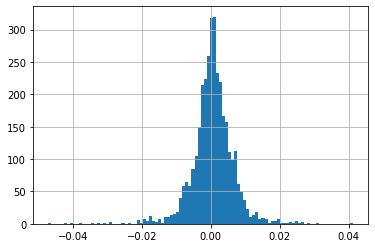

In [62]:
pandas.Series(Y_train.ravel()).hist(bins=100)

In [42]:
# Modelling

In [43]:
# set model specification

tsi_names = ['PublishDate']
y_names = ['target']
x_names = [x for x in data.columns.values if x not in y_names and x not in tsi_names]

In [44]:
# transformations
# all of them are in the .json file

with open('./transformers.json') as f:
    transformers = json.load(f)

transformers

{'StandardScaler': {},
 'MinMaxScaler': {'feature_range': [[0, 1], [-1, 1]]},
 'MaxAbsScaler': {},
 'Normalizer': {'norm': ['l1', 'l2', 'max']}}

In [57]:
# sample

test_rate = 0.2
T_, X_, Y_ = numpy.array(tsi_names), numpy.array(x_names), numpy.array(y_names)
T, X, Y = data[T_].values, data[X_].values, data[Y_].values
T_train, T_test, X_train, X_test, Y_train, Y_test = train_test_split(T, X, Y, test_size=test_rate)

In [46]:
"""
model realisation party A-00-1-SK: sklearn-interfaced models
"""
pass

In [47]:
# models
# all of them are stored in .json file with possible parameters

with open('./models_params.json') as f:
    models_params = json.load(f)

models_params

{'LinearRegression': {'n_jobs': [-1]},
 'ElasticNet': {'alpha': [0.01, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99],
  'l1_ratio': [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99],
  'max_iter': [100000]},
 'KNeighborsRegressor': {'n_neighbors': [2, 3, 5, 8, 10],
  'weights': ['uniform', 'distance'],
  'p': [1, 2],
  'n_jobs': [-1]},
 'LinearSVR': {'epsilon': [0.0, 0.1, 0.5, 1.0],
  'C': [0.1, 1.0, 10.0, 100.0],
  'max_iter': [100000]},
 'SVR': {'kernel': ['poly', 'rbf', 'sigmoid'],
  'gamma': ['auto', 'scale'],
  'C': [0.1, 1.0, 10.0, 100.0],
  'epsilon': [0.0, 0.1, 0.5, 1.0],
  'shrinking': [True, False],
  'max_iter': [100000]},
 'NuSVR': {'nu': [0.1, 0.25, 0.5, 0.75, 1.0],
  'C': [0.1, 1.0, 10.0, 100.0],
  'kernel': ['poly', 'rbf', 'sigmoid'],
  'gamma': ['auto', 'scale'],
  'shrinking': [True, False],
  'max_iter': [100000]},
 'DecisionTreeRegressor': {'splitter': ['best', 'random'],
  'max_depth': [None, 10, 5, 2],
  'max_features': ['auto', 'sqrt', 'log2']},
 'ExtraTreesRegressor': {'n_estimato

In [48]:
def multiply_params(params):
    keys = numpy.array(list(params.keys()))
    dims = numpy.array([len(params[keys[j]]) for j in numpy.arange(keys.shape[0])])
    result = []
    for j in numpy.arange(dims.prod()):
        curr = j
        res = {}
        for k in numpy.arange(keys.shape[0]):
            ix = curr % dims[k]
            res[keys[k]] = params[keys[k]][ix]
            curr = curr // dims[k]
        result.append(res)
    return result


In [49]:
def r2_adj(y_true, y_pred, dim0, dim1):
    r2 = r2_score(y_true, y_pred)
    result = 1 - (1 - r2) * (dim0 - 1) / (dim0 - dim1 -1)
    return result

In [50]:
X_train.shape, X_test.shape

((851, 1), (3401, 1))

In [51]:
dim_transform = 0
for transformer_name, transformer_params in transformers.items():
    multiple_transformer_params = multiply_params(transformer_params)
    dim_transform += len(multiple_transformer_params)
dim_transform

7

In [52]:
dim_models = 0
for model_name, model_args in models_params.items():
    multiple_model_args = multiply_params(model_args)
    dim_models += len(multiple_model_args)
dim_models

16569

In [53]:
print('Total N of experiments: {}'.format(dim_transform * dim_models))

Total N of experiments: 115983


In [ ]:
# well, let's loop over that all (NO GOD PLEASE NOOOOOO)
# (kind: nofolds)

serie = 'USE'
scorer = r2_adj
report = pandas.DataFrame(columns=['XP', 'trans', 'trans_p', 'model', 'model_p', 'sc_train', 'sc_test', 'time'])
verbose_step = 1000

#_ = 1
xp = 1
total_time = time.time()
for transformer_name, transformer_params in transformers.items():
    multiple_transformer_params = multiply_params(transformer_params)
    for transformer_param in multiple_transformer_params:
        x_transformer, y_transformer = locals()[transformer_name](**transformer_param), locals()[transformer_name](**transformer_param)
        x_transformer.fit(X_train)
        y_transformer.fit(Y_train)
        for model_name, model_args in models_params.items():
            multiple_model_args = multiply_params(model_args)
            for model_arg in multiple_model_args:
                model_time = time.time()
                model = locals()[model_name](**model_arg)
                X_train_transformed = x_transformer.transform(X_train)
                X_test_transformed = x_transformer.transform(X_test)
                Y_train_transformed = y_transformer.transform(Y_train)
                model.fit(X_train_transformed, Y_train_transformed.ravel())
                Y_hat_train_transformed = model.predict(X_train_transformed)
                Y_hat_test_transformed = model.predict(X_test_transformed)
                Y_hat_train = y_transformer.inverse_transform(Y_hat_train_transformed.reshape(-1, 1))
                Y_hat_test = y_transformer.inverse_transform(Y_hat_test_transformed.reshape(-1, 1))
                score_train = scorer(Y_train, Y_hat_train, X_train.shape[0], X_train.shape[1])
                score_test = scorer(Y_test, Y_hat_test, X_test.shape[0], X_test.shape[1])
                model_time = time.time() - model_time
                result = {'serie': serie, 'XP': xp, 'trans': transformer_name, 'trans_p': str(transformer_param), 'model': model_name, 'model_p': str(model_arg), 'sc_train': score_train, 'sc_test': score_test, 'time': model_time}
                report = report.append(result, ignore_index=True)
                #if _ == 1:
                #    print(model_name)
                if xp % verbose_step == 0:
                    print(xp)
                xp += 1
        _ += 1
total_time = time.time() - total_time
print('N experiments: {0:10}; Spent time: {1:.0f}h {2:.0f}m {3:.0f}s'.format(xp, (total_time // 3600), ((total_time // 60) % 60), ((total_time % 3600) % 60)))